In [1]:
    import numpy as np
    import math
    from datetime import timedelta
    from operator import attrgetter
    from netCDF4 import Dataset
    from netCDF4 import MFDataset
    from collections import defaultdict
    import xarray as xr
    import pandas as pd
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    import seaborn as sns
    import os

In [2]:
#showing graphs within Python
%matplotlib inline

In [3]:
'''
Written by Chad Valencia, chadvalencia@gmail.com

for David Lindo Atichati, PhD, CUNY

The following takes two datasets of cyclonic and anticyclonic
eddies over a cross-section of the Pacific Ocean in the northern
hemisphere and maps them by color; blue for cyclonic eddies
and red for anti-cyclonic eddies.

TO DO:
Removing a 1-degree margin on all sides to eliminate false readings along borders
of the test area

'''

'\nWritten by Chad Valencia, chadvalencia@gmail.com\n\nfor David Lindo Atichati, PhD, CUNY\n\nThe following takes two datasets of cyclonic and anticyclonic\neddies over a cross-section of the Pacific Ocean in the northern\nhemisphere and maps them by color; blue for cyclonic eddies\nand red for anti-cyclonic eddies.\n\nTO DO:\nRemoving a 1-degree margin on all sides to eliminate false readings along borders\nof the test area\n\n'

In [4]:
#importing Cyclonic dataset

In [5]:
cycnc = Dataset('./output_tracking/Cyclonic.nc')

In [6]:
#creating columns for cycnc dataframe
latlon = list(zip(cycnc['lat'],cycnc['lon']))

In [7]:
dates = list(cycnc['j1'])

In [8]:
eddy = list(cycnc['track'])

In [141]:
cdf = pd.DataFrame([eddy,dates,latlon]).T

In [142]:
cdf.columns=['eddy','date','position']

In [143]:
cdf['date']=pd.to_datetime(cdf['date'],origin='julian',unit='D')

In [144]:
'''
to see dataframe of eddy (by track number), date, and
position (longitude, latitude)

'''
cdf.head(20)

,eddy,date,position
0,1,2009-05-01 12:00:00,"(26.569246, -158.67618)"
1,1,2009-05-02 12:00:00,"(26.591457, -158.71062)"
2,1,2009-05-03 12:00:00,"(26.60262, -158.72865)"
3,1,2009-05-04 12:00:00,"(26.615175, -158.74513)"
4,2,2009-05-01 12:00:00,"(30.712801, 177.31134)"
5,2,2009-05-02 12:00:00,"(30.683573, 177.25815)"
6,2,2009-05-03 12:00:00,"(30.660034, 177.21356)"
7,2,2009-05-04 12:00:00,"(30.641605, 177.18173)"
8,2,2009-05-05 12:00:00,"(30.628326, 177.15967)"
9,2,2009-05-06 12:00:00,"(30.624702, 177.13596)"


In [145]:
#to verify date range
cdf.describe()

,eddy,date,position
count,176048.0,176048,176048
unique,10115.0,1851,176048
top,5210.0,2010-03-11 12:00:00,"(24.982084, -171.72005)"
freq,462.0,134,1
first,NaN,2009-05-01 12:00:00,NaN
last,NaN,2014-05-25 12:00:00,NaN


In [146]:
'''
To remove edge bias, a 1 degree border must be removed from both latitude and longitude.
The pos_compare function returns true if a trajectory point is within this margin.
The truecol function returns a modified dataframe with the margin.
'''
def pos_compare(tup):
    lat_in, lon_in = False, False
    lat=tup[0]
    lon=tup[1]
    if 15.92 < lat < 34.04043:
        lat_in = True
    if lon > 0:
        if 176.04 < float(lon):
            lon_in = True
    else:
        if lon < -150.9659:
            lon_in = True
    return lat_in and lon_in

def truecol(df):
    l=[]
    for i in df['position']:
        if pos_compare(i):
            l.append(True)
        else:
            l.append(False)
    df['truecol']=l
    df = df[df['truecol']==True]
    return df

In [147]:
#setting an adjusted dataframe
cdf = truecol(cdf)

In [148]:
cdf.describe()

,eddy,date,position,truecol
count,157718.0,157718,157718,157718
unique,9026.0,1851,157718,1
top,5210.0,2010-04-12 12:00:00,"(24.783854, -171.30133)",True
freq,462.0,118,1,157718
first,NaN,2009-05-01 12:00:00,NaN,NaN
last,NaN,2014-05-25 12:00:00,NaN,NaN


,eddy,date,position,truecol
count,157718.0,157718,157718,157718
unique,9026.0,1851,157718,1
top,5210.0,2010-04-12 12:00:00,"(24.783854, -171.30133)",True
freq,462.0,118,1,157718
first,NaN,2009-05-01 12:00:00,NaN,NaN
last,NaN,2014-05-25 12:00:00,NaN,NaN


In [149]:
#doing similar work with Anticyclonic
acycnc = Dataset('./output_tracking/Anticyclonic.nc')

In [150]:
#defining a function for future use
def dfnc(nc):
    '''
    This takes an nc dataset and creates a Pandas dataframe
    with columns eddy, date and position
    '''
    latlon = list(zip(nc['lat'],nc['lon']))
    dates = list(nc['j1'])
    eddy = list(nc['track'])
    df = pd.DataFrame([eddy,dates,latlon]).T
    df.columns=['eddy','date','position']
    df['date']=pd.to_datetime(df['date'],origin='julian',unit='D')
    return df

In [151]:
adf = dfnc(acycnc)

In [152]:
adf.head(20)

,eddy,date,position
0,1,2009-05-01 12:00:00,"(16.711275, -158.20699)"
1,1,2009-05-02 12:00:00,"(16.678257, -158.28957)"
2,1,2009-05-03 12:00:00,"(16.68945, -158.41434)"
3,1,2009-05-04 12:00:00,"(16.632107, -158.48706)"
4,1,2009-05-05 12:00:00,"(16.580832, -158.55283)"
5,1,2009-05-06 12:00:00,"(16.65199, -158.64769)"
6,2,2009-05-01 12:00:00,"(19.849276, -152.099)"
7,2,2009-05-02 12:00:00,"(19.811481, -152.15033)"
8,2,2009-05-03 12:00:00,"(19.806429, -152.20308)"
9,2,2009-05-04 12:00:00,"(19.815142, -152.2497)"


In [153]:
adf.describe()

,eddy,date,position
count,140232.0,140232,140232
unique,8632.0,1851,140232
top,3662.0,2013-03-09 12:00:00,"(24.562706, -171.66272)"
freq,292.0,102,1
first,NaN,2009-05-01 12:00:00,NaN
last,NaN,2014-05-25 12:00:00,NaN


In [154]:
adf = truecol(adf)
adf.describe()

,eddy,date,position,truecol
count,128386.0,128386,128386,128386
unique,7803.0,1851,128386,1
top,3662.0,2010-05-07 12:00:00,"(24.409733, -171.18294)",True
freq,292.0,93,1,128386
first,NaN,2009-05-01 12:00:00,NaN,NaN
last,NaN,2014-05-25 12:00:00,NaN,NaN


In [155]:
'''
the following steps will create a python dictionary of cyclonic eddies by track number
where values of each eddy are the central longitude and latitude for each eddy
throughout the life cycle of the eddy.
'''

'\nthe following steps will create a python dictionary of cyclonic eddies by track number\nwhere values of each eddy are the central longitude and latitude for each eddy\nthroughout the life cycle of the eddy.\n'

In [156]:
c_eddy=defaultdict(list)

In [157]:
#pandas function, populating the empty c_eddy list with coordinates
cdf.apply(lambda row: c_eddy[row['eddy']].append(row['position']), axis=1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
176014    None
176015    None
176016    None
176017    None
176018    None
176023    None
176024    None
176025    None
176026    None
176027    None
176028    None
176029    None
176030    None
176031    None
176032    None
176033    None
176034    None
176035    None
176036    None
176037    None
176038    None
176039    None
176040    None
176041    None
176042    None
176043    None
176044    None
176045    None
176046    None
176047    None
Length: 157718, dtype: object

In [158]:
#testing c_eddy, a list of coordinates for cyclonic eddy path travel.
for i in np.arange(10):
    print(c_eddy[i+1])

[(26.569246, -158.67618), (26.591457, -158.71062), (26.60262, -158.72865), (26.615175, -158.74513)]
[(30.712801, 177.31134), (30.683573, 177.25815), (30.660034, 177.21356), (30.641605, 177.18173), (30.628326, 177.15967), (30.624702, 177.13596), (30.62316, 177.11816), (30.631697, 177.0906), (30.647179, 177.05086), (30.664234, 177.00108), (30.680347, 176.94118), (30.697508, 176.88812), (30.719954, 176.83507), (30.746065, 176.78055), (30.769968, 176.73224), (30.792746, 176.68765), (30.824505, 176.63995), (30.866734, 176.59615), (30.911306, 176.55992), (30.959606, 176.52568), (31.017883, 176.49672), (31.082201, 176.47968), (31.145897, 176.47246), (31.204075, 176.4639), (31.264893, 176.45914), (31.325378, 176.46759), (31.384722, 176.47742), (31.444601, 176.49359), (31.501057, 176.52022), (31.549524, 176.54759), (31.597063, 176.58728), (31.64574, 176.65118)]
[(28.183327, -159.13167), (28.185577, -159.13365), (28.183346, -159.13065), (28.189713, -159.1111), (28.189322, -159.10402), (28.192924

In [159]:
len(c_eddy)

9026

In [160]:
#creating a similar dictionary for anticylconic eddies
a_eddy=defaultdict(list)
adf.apply(lambda row: a_eddy[row['eddy']].append(row['position']), axis=1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
140194    None
140195    None
140196    None
140197    None
140198    None
140199    None
140200    None
140201    None
140202    None
140203    None
140204    None
140205    None
140206    None
140207    None
140208    None
140209    None
140210    None
140211    None
140212    None
140213    None
140214    None
140215    None
140216    None
140217    None
140218    None
140219    None
140228    None
140229    None
140230    None
140231    None
Length: 128386, dtype: object

In [161]:
#testing a_eddy
for i in np.arange(10):
    print(a_eddy[i+1])

[(16.711275, -158.20699), (16.678257, -158.28957), (16.68945, -158.41434), (16.632107, -158.48706), (16.580832, -158.55283), (16.65199, -158.64769)]
[(19.849276, -152.099), (19.811481, -152.15033), (19.806429, -152.20308), (19.815142, -152.2497), (19.818892, -152.28809), (19.807768, -152.32928), (19.828451, -152.38104), (19.868013, -152.42871), (19.86178, -152.45703), (19.849306, -152.49315), (19.84319, -152.54086), (19.87202, -152.59186), (19.992334, -152.67372), (19.927107, -152.6799)]
[(30.187067, -173.6266), (30.189524, -173.62906), (30.195122, -173.63745), (30.200968, -173.64659), (30.212212, -173.66193), (30.204102, -173.6577), (30.215345, -173.66405), (30.212831, -173.67627), (30.218115, -173.67918), (30.232698, -173.68018), (30.288223, -173.67482), (30.303312, -173.68033), (30.313496, -173.66858), (30.32408, -173.66344), (30.383512, -173.52673), (30.37288, -173.49379), (30.278255, -173.64539), (30.249481, -173.64247), (30.184875, -173.67287), (30.104399, -173.70961), (30.173416

In [162]:
len(a_eddy)

7803

In [36]:
#test for final, nsper seems to have a better view of the northern hemisphere.
#still trying to figure out how to zoom into a larger area

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


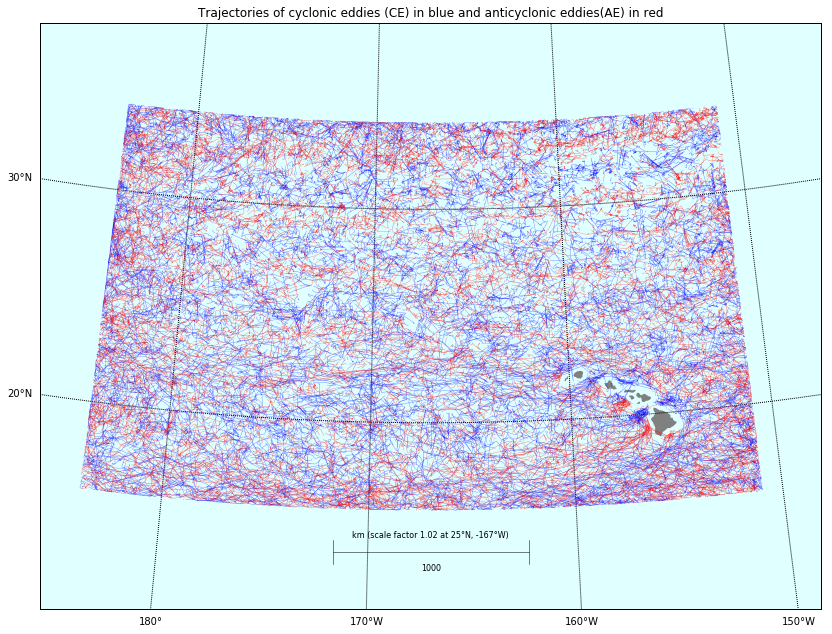

In [216]:
plt.figure(figsize=(14,14))
m = Basemap(width=4000000,height=3000000,projection='lcc',
            resolution='f',lat_1=14,lat_2=36,lat_0=25,lon_0=-167.)
# changing resolution to 'f' gives full resolution
m.drawmapboundary(fill_color='lightcyan')
m.fillcontinents(color='grey', lake_color='lightcyan')
m.drawparallels(np.arange(-90.,120.,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(0.,420.,10), labels=[False,False,False,True])
m.drawmapscale(lon=-167,lat=14,lon0=-167,lat0=25,length=1000,labelstyle='fancy', fontsize=8, linewidth=.5)
for j in np.arange(1,9027):
    #max 9027
    if len(c_eddy[j])>0:
        lon = [i[1] for i in c_eddy[j]]
        lat = [i[0] for i in c_eddy[j]]
        x, y = m(lon, lat)
        m.plot(x, y, linewidth=.4, color='blue', alpha=.5 )
for k in np.arange(1,7804):
    #max 7804
    if len(a_eddy[k])>0:
        lon = [i[1] for i in a_eddy[k]]
        lat = [i[0] for i in a_eddy[k]]
        x, y = m(lon, lat)
        m.plot(x, y, linewidth=.4, color='red', alpha=.5)
plt.title('Trajectories of cyclonic eddies (CE) in blue and anticyclonic eddies(AE) in red')
plt.savefig('northhemi.png')
plt.show()